In [2]:
import numpy as np 
import pandas as pd 
from sklearn.decomposition import PCA, FastICA,  IncrementalPCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import cluster
from glob import glob
import random
import cv2
from keras.preprocessing.image import img_to_array, load_img 
from keras.applications.vgg16 import preprocess_input, VGG16
from keras.models import Model

In [123]:
images=random.sample(glob('crop_part1/*'),500)
img = load_img(images[0], target_size=(224,224))
# convert from 'PIL.Image.Image' to numpy array
img = np.array(img)

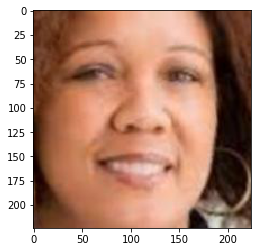

In [124]:
plt.imshow(img)

In [127]:
data = {}
for image in images:
    data[image] = np.array(load_img(image)).flatten().reshape(1,120000)

In [128]:
keys = np.array(list(data.keys()))
feats = np.array(list(data.values()))

In [129]:
nsamples, nx, ny = feats.shape
feats = feats.reshape((nsamples,nx*ny))

In [130]:
feats

array([[115,  68,  48, ..., 146, 120, 103],
       [ 87,  48,  43, ..., 181, 111,  49],
       [162, 168, 156, ...,  46,  41,  22],
       ...,
       [120, 124, 135, ..., 141, 144, 149],
       [ 82,  59,  53, ..., 116, 102,  93],
       [165, 177, 127, ...,  79,  81,  70]], dtype=uint8)

In [150]:
pca = PCA(n_components=70)
transformed_images=pca.fit_transform(feats)

In [151]:
print(f"Components before PCA: {len(feats[0])}")
print(f"Components after PCA: {pca.n_components}")

Components before PCA: 120000
Components after PCA: 70


In [152]:
#so the first 100 components explains 90 % of the variance
np.cumsum(pca.explained_variance_ratio_)

array([0.28715459, 0.4107847 , 0.52010404, 0.563676  , 0.59232321,
       0.61809939, 0.64290883, 0.66157716, 0.67907838, 0.69457734,
       0.70862036, 0.72189788, 0.73225028, 0.74195521, 0.74999035,
       0.75779145, 0.76478711, 0.77150822, 0.77778259, 0.78378516,
       0.78945264, 0.79485738, 0.79993593, 0.80467591, 0.80921778,
       0.81356293, 0.81746205, 0.82130339, 0.8247931 , 0.82805119,
       0.83124383, 0.83427134, 0.83729085, 0.84022411, 0.84302636,
       0.84565898, 0.84822445, 0.85075272, 0.8532446 , 0.85561885,
       0.85794161, 0.86021125, 0.86235729, 0.86444624, 0.86648821,
       0.8684242 , 0.87026889, 0.87207856, 0.87382471, 0.87550816,
       0.87716232, 0.87878772, 0.88037412, 0.8819453 , 0.88349703,
       0.88498147, 0.88643597, 0.88782924, 0.88920262, 0.89055537,
       0.89187127, 0.89316958, 0.89442563, 0.89565758, 0.89687341,
       0.89806823, 0.89921842, 0.90033648, 0.90143453, 0.90251452])

In [153]:
ica = FastICA(n_components=20)
transformed_images_ica = ica.fit_transform(transformed_images)

In [154]:
kmeans = KMeans(n_clusters=10 ,n_jobs=6, random_state=42)
kmeans.fit(transformed_images)

KMeans(n_clusters=10, n_jobs=6, random_state=42)

[clustimage] >WARNING> Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


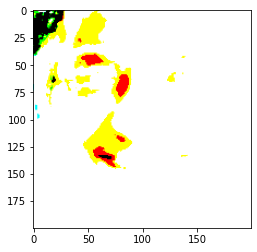

In [181]:
plt.imshow(pca.inverse_transform(transformed_images[4]).reshape(200,200,3))

In [155]:
groups = {}
for file, cluster in zip(images,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

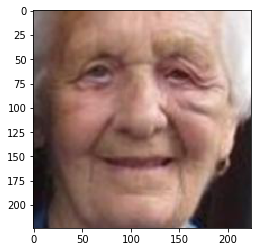

In [156]:
count=0
temp=[]
clusterNR = 3
for i in groups[clusterNR]:
    temp.append(load_img((glob(str(groups[clusterNR][count])))[0],target_size=(224,224)))
    count +=1
plt.imshow(temp[4])

In [157]:
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    files = groups[cluster]
    if len(files) > 50:
        files = files[:50]
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Cluster{cluster}')

In [195]:
groups[2]
temp=[]
for i in groups[2]:
    temp.append(i.replace('crop_part1\\',''))

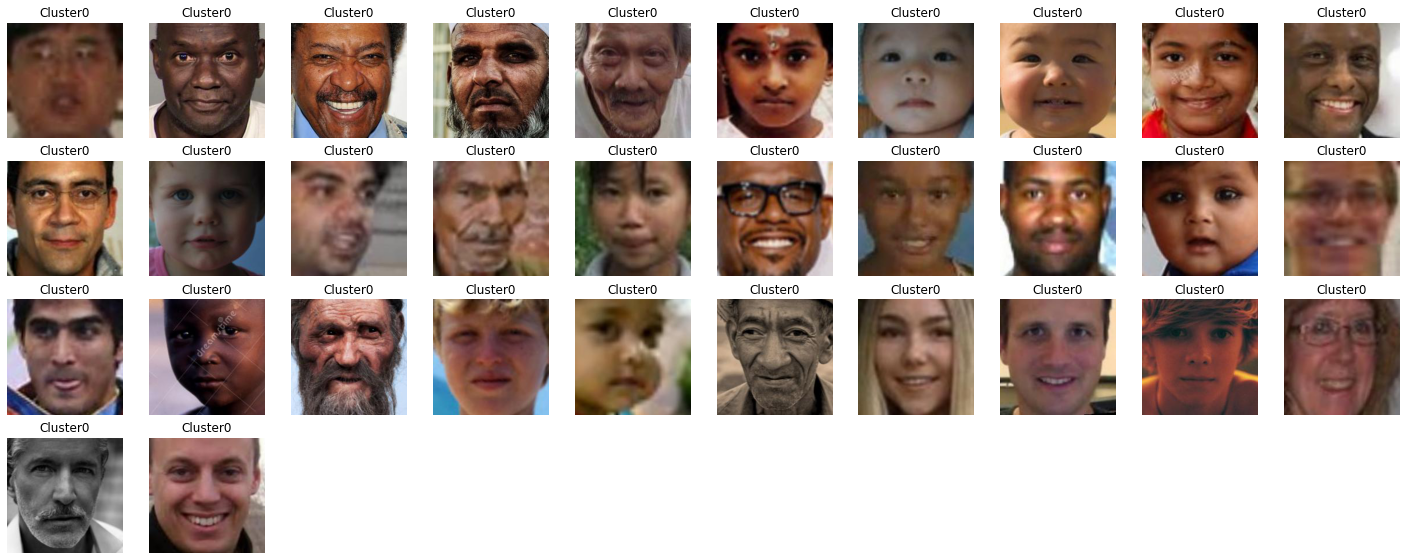

In [160]:
view_cluster(0)

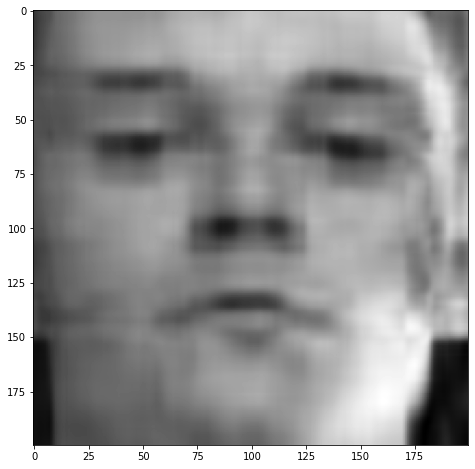

In [242]:
pca = PCA(n_components=4)
image_recon = pca.inverse_transform(pca.fit_transform(X[0]))

# Plotting the reconstructed image
plt.figure(figsize=[12,8])
plt.imshow(image_recon,cmap = plt.cm.gray)

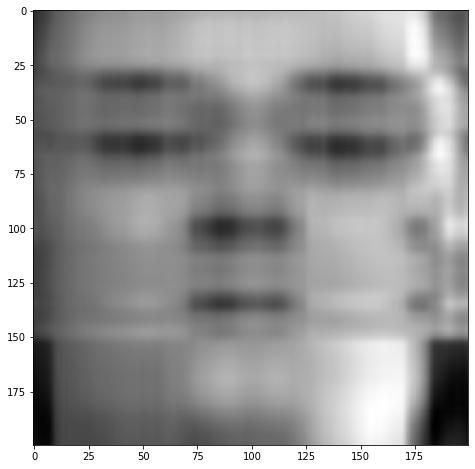

In [234]:
ica = FastICA(n_components=3)
image_recon_ica = ica.inverse_transform(ica.fit_transform(image_recon))
 
# Plotting the reconstructed image
plt.figure(figsize=[12,8])
plt.imshow(image_recon_ica,cmap = plt.cm.gray)